# --------------------------- Belgian Grid Forecasting ---------------------------

## 1. Set up

### 1.1. Libraries

In [22]:
import json
import logging
import tim_client
import pandas as pd
import os
import plotly as plt
import plotly.express as px
import plotly.graph_objects as go

### 1.2. TIM

In [23]:
credentials_json = json.load(open('credentials.json'))
logging.basicConfig(level= logging.getLevelName('INFO'), format='[%(levelname)s] %(asctime)s - %(name)s:%(funcName)s:%(lineno)s - %(message)s')
logger = logging.getLogger(__name__)
credentials = tim_client.Credentials(credentials_json['license_key'], credentials_json['email'], credentials_json['password'], tim_url='https://timws.tangent.works/latest/api')
api_client = tim_client.ApiClient(credentials)
api_client.save_json = True
api_client.json_saving_folder_path = 'logs/'

[INFO] 2021-05-07 15:47:36,783 - tim_client.api_client:save_json:66 - Saving JSONs functionality has been enabled
[INFO] 2021-05-07 15:47:36,784 - tim_client.api_client:json_saving_folder_path:75 - JSON destination folder changed to logs


## 2. Get Data

### 2.1. Target

In [24]:
target_data_df = pd.read_csv('Energy_Data.csv')
target_data_df['Timestamp'] = pd.to_datetime(target_data_df['Timestamp'])

### 2.2. Weather

In [25]:
path = os.getcwd()
hw_df = pd.read_csv(path+'/historical_weather_all_dates.csv')
wfh_df = pd.read_csv(path+'/weather_forecast_hourly_all_dates.csv')

wfh_df = wfh_df.sort_values(by=['dt','run_date'],ascending=False)
wfh_df['select'] = wfh_df.groupby('dt').cumcount()
wfh_df = wfh_df[wfh_df['select']==0].sort_values(by=['dt']).drop(columns=['run_date','select'])

hw_df = hw_df.sort_values(by=['dt','run_date'],ascending=False)
hw_df['select'] = hw_df.groupby('dt').cumcount()
hw_df = hw_df[hw_df['select']==0].sort_values(by=['dt']).drop(columns=['run_date','select'])

hw_df['type'] = 'H'
wfh_df['type'] = 'F'
combo_df = hw_df.append(wfh_df[wfh_df['dt']>hw_df['dt'].max()])
combo_df['Timestamp'] = pd.to_datetime(combo_df['dt'])

### 2.3. Public Holidays

In [26]:
ph_df = pd.read_csv('PH_TIM.csv',sep=';')

### 2.4. Combine Data

In [27]:
raw_data = target_data_df.merge(combo_df[combo_df['Timestamp']>=target_data_df['Timestamp'].min()],on='Timestamp',how='outer').drop(columns=['dt','type'])
raw_data['Date'] = raw_data['Timestamp'].dt.floor('d').dt.strftime('%Y-%m-%d %H:%M:%S')
tim_input = raw_data.merge(ph_df,on='Date',how='left').drop(columns=['Date']).sort_values(by='Timestamp').reset_index(drop=True)

### 2.5. Visualize Data

In [28]:
tim_input

Timestamp  Quantity   temp  feels_like  pressure  humidity  \
0    2021-01-20 16:00:00   11591.0  10.14        3.06       996        57   
1    2021-01-20 17:00:00   12305.0   9.96        3.22       993        57   
2    2021-01-20 18:00:00   11919.0  10.26        3.41       993        62   
3    2021-01-20 19:00:00   11461.0  10.41        5.03       993        62   
4    2021-01-20 20:00:00   10751.0  10.46        4.38       993        71   
...                  ...       ...    ...         ...       ...       ...   
2603 2021-05-09 03:00:00       NaN  12.69       12.13      1004        81   
2604 2021-05-09 04:00:00       NaN  12.59       11.99      1003        80   
2605 2021-05-09 05:00:00       NaN  13.36       12.92      1003        83   
2606 2021-05-09 06:00:00       NaN  14.40       14.14      1003        86   
2607 2021-05-09 07:00:00       NaN  15.64       15.43      1003        83   

      dew_point  clouds  visibility  wind_speed  wind_deg  wind_gust  rain  \
0          2.01       0     10000.0        7.72       190       0.00  0.00   
1          1.84       0     10000.0        7.20       180       0.00  0.00   
2          3.31       0     10000.0        7.72       190       0.00  0.00   
3          3.45       0     10000.0        5.66       180       0.00  0.00   
4          5.43      75     10000.0        7.20       200       0.00  0.50   
...         ...     ...         ...         ...       ...        ...   ...   
2603       9.48     100     10000.0        4.79       164      13.77  0.00   
2604       9.26      90     10000.0        4.81       161      13.26  0.00   
2605      10.54      92     10000.0        5.33       174      14.76  0.21   
2606      12.07      93     10000.0        5.62       173      14.15  0.63   
2607      12.81     100     10000.0        5.66       181      14.92  0.41   

      snow  IsPublicHoliday  IsSchoolHoldiday  IsHolidayPeriod  
0      0.0                0                 0                0  
1      0.0                0                 0                0  
2      0.0                0                 0                0  
3      0.0                0                 0                0  
4      0.0                0                 0                0  
...    ...              ...               ...              ...  
2603   0.0                0                 0                0  
2604   0.0                0                 0                0  
2605   0.0                0                 0                0  
2606   0.0                0                 0                0  
2607   0.0                0                 0                0  

[2608 rows x 17 columns]

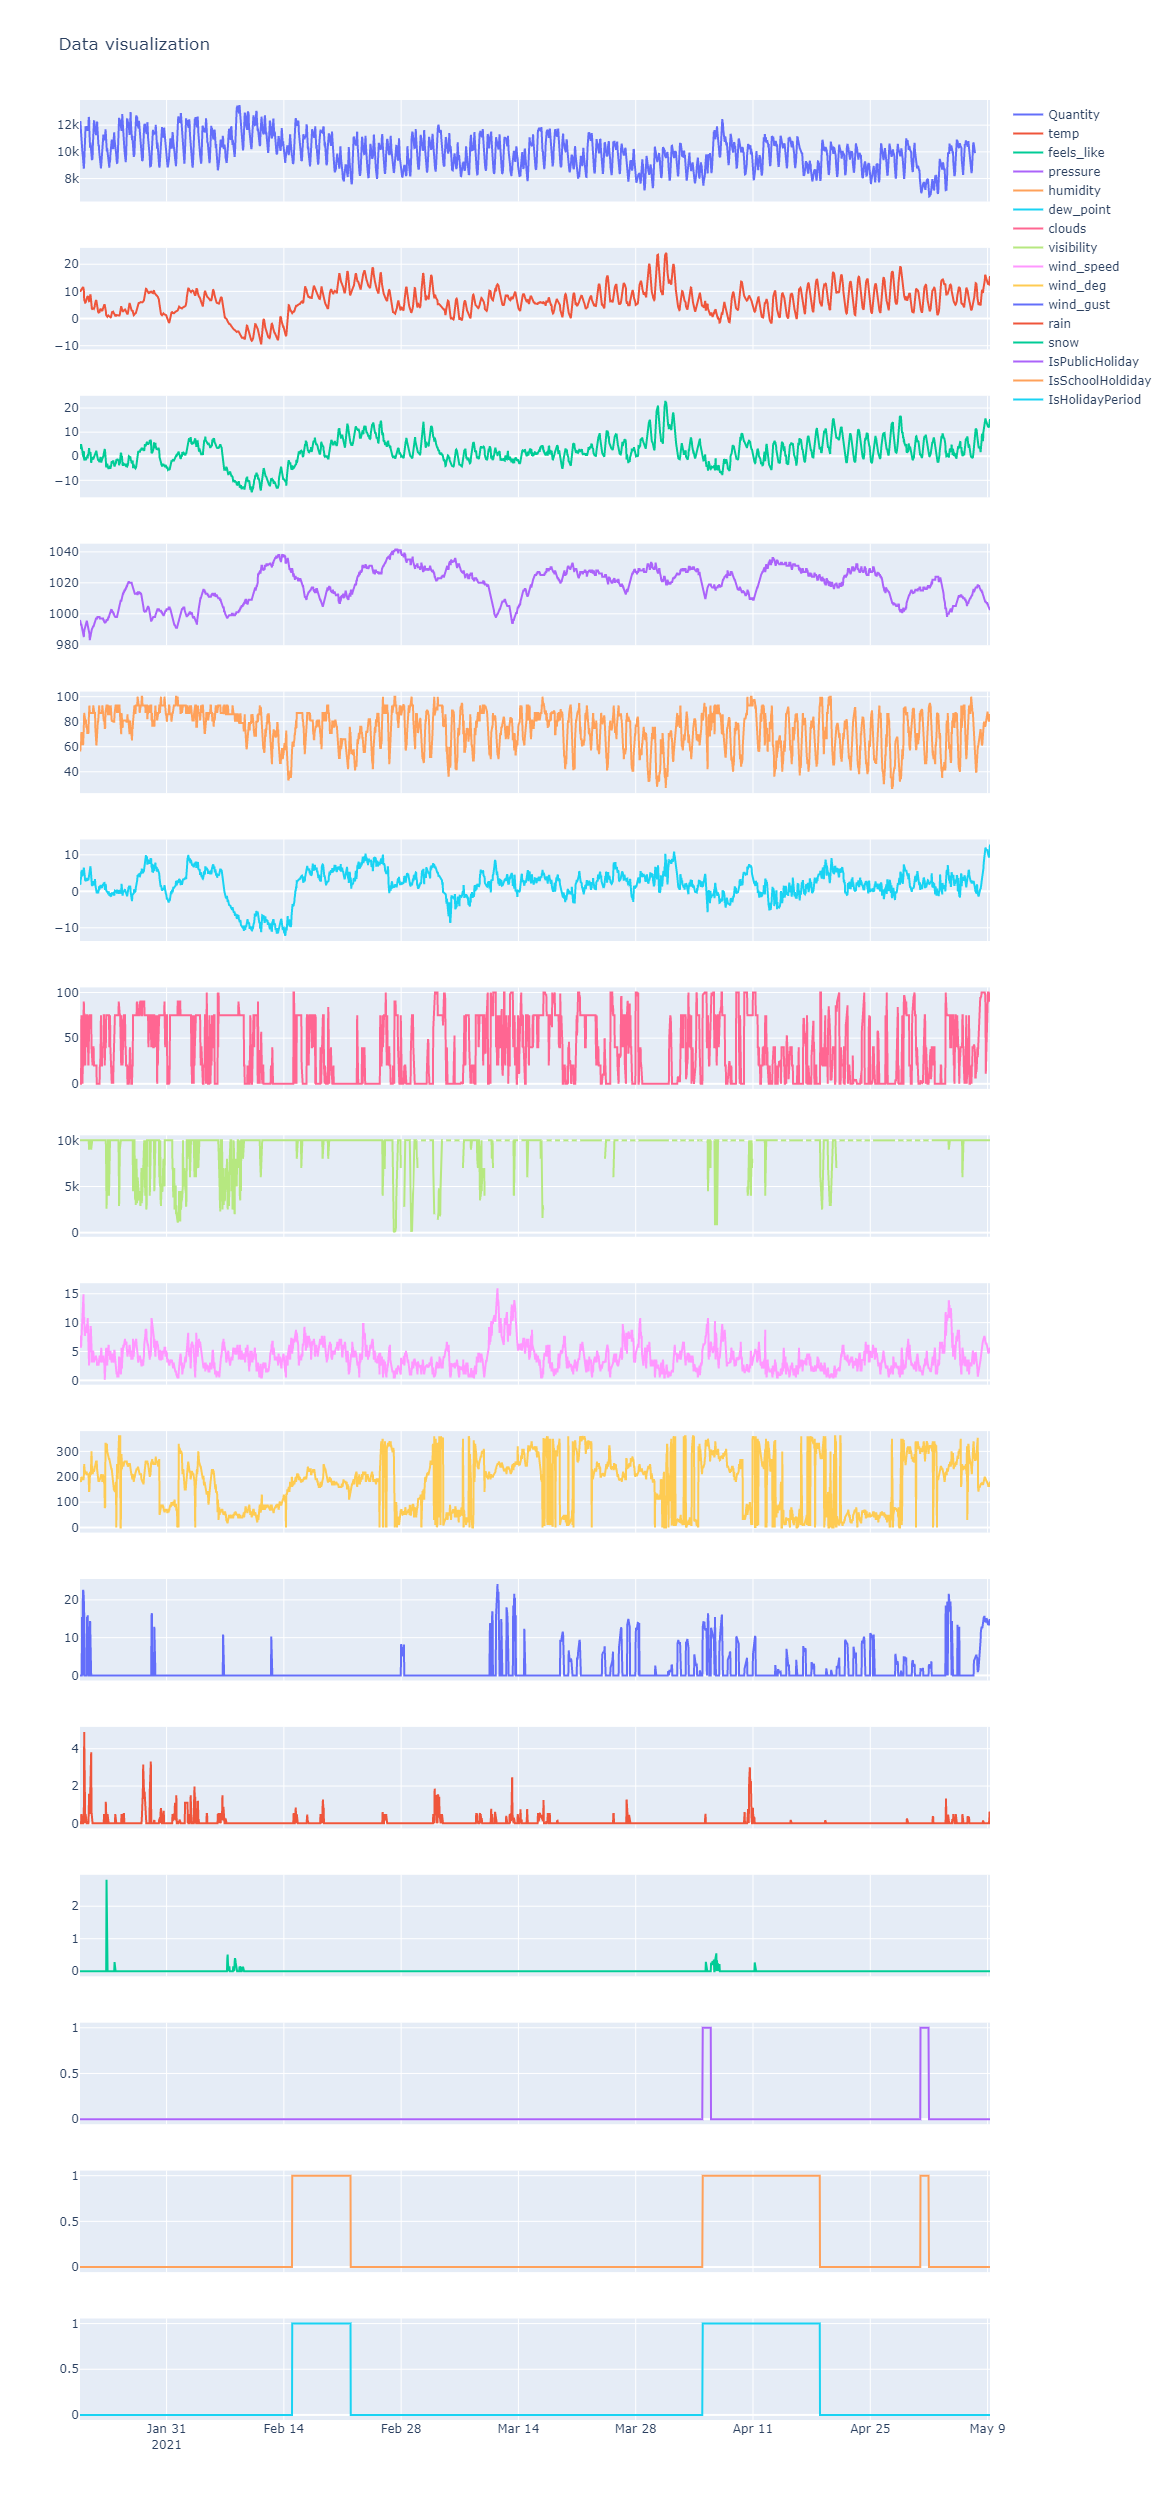

In [31]:
data = tim_input
nb_rows = len(data.columns)
p_list = list(data.columns[1:nb_rows+1])
x_axis = 'Timestamp'

fig = plt.subplots.make_subplots(rows=nb_rows-1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
i=0
for p in p_list:
    i+=1
    fig.add_trace(go.Scatter(x=data[x_axis], y=data[p], name=p), row=i, col=1)
    
fig.update_layout(height=2500, width=1200, title_text="Data visualization")
fig.show()    

## 3. Live Forecast with TIM

### 3.1. Configuration

In [32]:
target_variable = 'Quantity'
backtestLength = 48
forecastingHorizon = 24
confidenceLevel = 90

rtiml_configuration = {'usage': {'predictionTo': {'baseUnit': 'Sample', 'offset': forecastingHorizon},'backtestLength': backtestLength},"predictionIntervals": {"confidenceLevel": confidenceLevel},
    'extendedOutputConfiguration': {
        'returnSimpleImportances': True,
        'returnExtendedImportances': True
    }
}

### 3.2. TIM API Call

In [33]:
uuids = api_client.prediction_build_model_predict(tim_input,rtiml_configuration,wait_to_finish = False).request_uuid
while True:
    rtiml_prediction = api_client.prediction_build_model_predict_detail(uuids)
    print(rtiml_prediction.status+" "+str(rtiml_prediction.progress),end='\r')
    if rtiml_prediction.status == "Running": continue 
    else: break

print(rtiml_prediction.status+" "+str(rtiml_prediction.progress))
for i in rtiml_prediction.events:
    if "Warning" in i['message']: print(i['message'])
print('Runtime: '+str(pd.to_datetime(pd.DataFrame(rtiml_prediction.events)['dateTime'].iloc[-1])-(pd.to_datetime(pd.DataFrame(rtiml_prediction.events)['dateTime']).iloc[0])))

FinishedWithWarning 100.0
SuccessfulWithWarning
Runtime: 0 days 00:00:02.943000


### 3.3. Collect Results

In [34]:
# ------------------------------ Predictions ------------------------------
prediction_df = rtiml_prediction.get_prediction(include_intervals=True).reset_index()
prediction_df['Timestamp'] = pd.to_datetime(prediction_df['Timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')
# ------------------------------ Aggregated Predictions & Accuracy ------------------------------
aggregated_predictions_df = pd.DataFrame()
accuracy_metrics = pd.DataFrame()
for ag in rtiml_prediction.aggregated_predictions:
    ag_df = pd.DataFrame(ag['values']).reset_index()
    ag_df['day'] = ag['day']
    ag_df = ag_df.rename(columns={'Prediction':ag['type']})
    aggregated_predictions_df = aggregated_predictions_df.append(ag_df)
    acc_df = pd.json_normalize(ag['accuracyMetrics'])
    acc_df['day'] = ag['day']
    acc_df['type'] = ag['type']
    accuracy_metrics = accuracy_metrics.append(acc_df)
aggregated_predictions_df['Timestamp'] = pd.to_datetime(aggregated_predictions_df['Timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')
# ------------------------------ Insights ------------------------------
pi_df = pd.DataFrame(rtiml_prediction.predictors_importances['simpleImportances'])
fi_df = pd.DataFrame(rtiml_prediction.predictors_importances['extendedImportances'])
# ------------------------------ Events ------------------------------
events_df = pd.DataFrame(rtiml_prediction.events)
# ------------------------------ Actuals ------------------------------
actuals_df = tim_input[['Timestamp',target_variable]].rename(columns={target_variable:'Actuals'}).dropna()
actuals_df['Timestamp'] = actuals_df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
# ------------------------------ Results ------------------------------
results_df = actuals_df.append(prediction_df).merge(aggregated_predictions_df[['Timestamp','inSample','outOfSample']],on='Timestamp',how='left')
# ------------------------------ Input information ------------------------------
last_timestamp = tim_input[tim_input[target_variable].notnull()]['Timestamp'].idxmax()
start_training = tim_input['Timestamp'].min()
end_training = tim_input[tim_input.index==last_timestamp-backtestLength]['Timestamp'].min()
start_test = tim_input[tim_input.index==last_timestamp-backtestLength+1]['Timestamp'].min()
end_test = tim_input[tim_input[target_variable].notnull()]['Timestamp'].max()
start_forecast = tim_input[tim_input.index==last_timestamp+1]['Timestamp'].min()
end_forecast = tim_input[tim_input.index==last_timestamp+forecastingHorizon]['Timestamp'].min()

### 3.4. Visualize Results

#### 3.4.1. Values

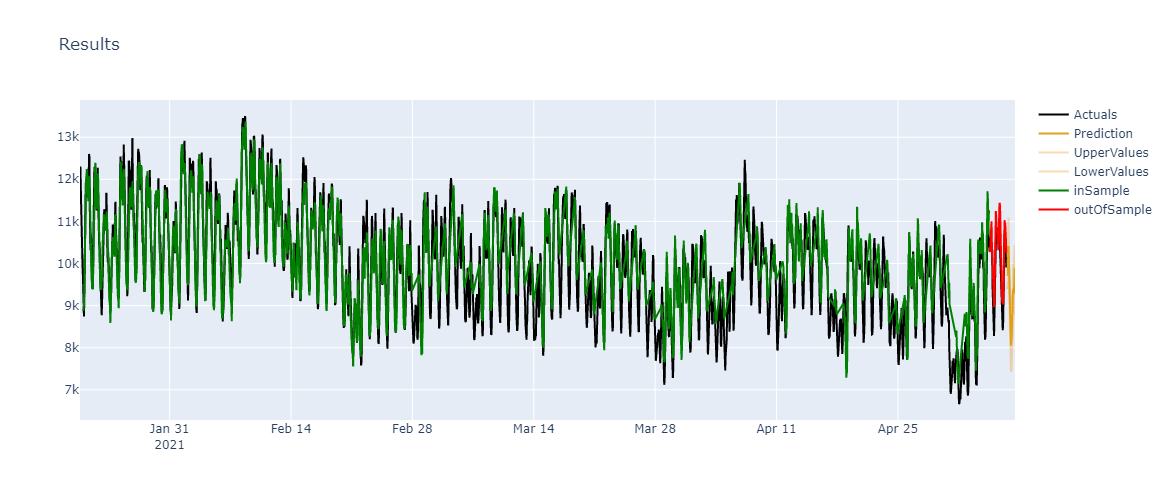

Training Period:  from  2021-01-20 16:00:00  to  2021-05-05 12:00:00  = 104 days 21:00:00
Test Period:      from  2021-05-05 13:00:00  to  2021-05-07 12:00:00  = 2 days 00:00:00
Forecast Period:  from  2021-05-07 13:00:00  to  2021-05-08 12:00:00  = 1 days 00:00:00


In [35]:
v_data = results_df
x_axis = 'Timestamp'
actuals = 'Actuals'
prediction = 'Prediction'
inSample = 'inSample'
outOfSample = 'outOfSample'
upper = 'UpperValues'
lower = 'LowerValues'

fig = go.Figure(go.Scatter(x=actuals_df[x_axis], y=actuals_df[actuals], name=actuals, line=dict(color='black')))
fig.add_trace(go.Scatter(x=prediction_df[x_axis], y=prediction_df[prediction], name=prediction, line=dict(color='goldenrod')))
fig.add_trace(go.Scatter(x=prediction_df[x_axis], y=prediction_df[upper], name=upper, line=dict(color='rgba(240,140,0,0.3)')))
fig.add_trace(go.Scatter(x=prediction_df[x_axis], y=prediction_df[lower], name=lower, line=dict(color='rgba(240,140,0,0.3)')))
fig.add_trace(go.Scatter(x=aggregated_predictions_df[x_axis], y=aggregated_predictions_df[inSample], name=inSample, line=dict(color='green')))
fig.add_trace(go.Scatter(x=aggregated_predictions_df[x_axis], y=aggregated_predictions_df[outOfSample], name=outOfSample, line=dict(color='red')))
fig.update_layout(height=500, width=1200, title_text="Results")
fig.show()
print("Training Period:  from  "+str(start_training)+"  to  "+str(end_training)+"  = "+str(end_training-start_training+pd.Timedelta(hours=1)))
print("Test Period:      from  "+str(start_test)+"  to  "+str(end_test)+"  = "+str(end_test-start_test+pd.Timedelta(hours=1)))
print("Forecast Period:  from  "+str(start_forecast)+"  to  "+str(end_forecast)+"  = "+str(end_forecast-start_forecast+pd.Timedelta(hours=1)))

#### 3.4.2. Accuracy

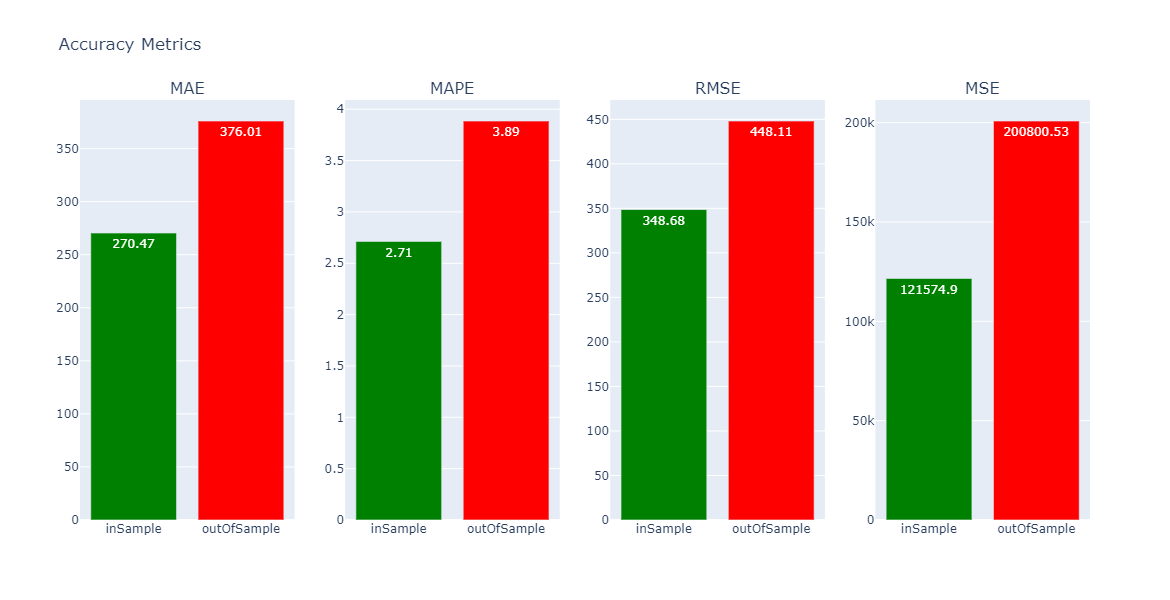

In [36]:
b_data = accuracy_metrics
fig = plt.subplots.make_subplots(rows=1, cols=4,subplot_titles=('MAE','MAPE','RMSE','MSE'))
fig.add_trace(go.Bar(x=b_data['type'], y=b_data['MAE'],text=round(b_data['MAE'],2),textposition='auto',marker=dict(color=['green','red'])),1,1)
fig.add_trace(go.Bar(x=b_data['type'], y=b_data['MAPE'],text=round(b_data['MAPE'],2),textposition='auto',marker=dict(color=['green','red'])),1,2)
fig.add_trace(go.Bar(x=b_data['type'], y=b_data['RMSE'],text=round(b_data['RMSE'],2),textposition='auto',marker=dict(color=['green','red'])),1,3)
fig.add_trace(go.Bar(x=b_data['type'], y=b_data['MSE'],text=round(b_data['MSE'],2),textposition='auto',marker=dict(color=['green','red'])),1,4)
fig.update_layout(height=600, width=1400, title_text="Accuracy Metrics",showlegend=False)
fig.show()

#### 3.4.3. Insights

Predictors not used:['rain', 'clouds', 'visibility', 'wind_speed', 'feels_like', 'snow']


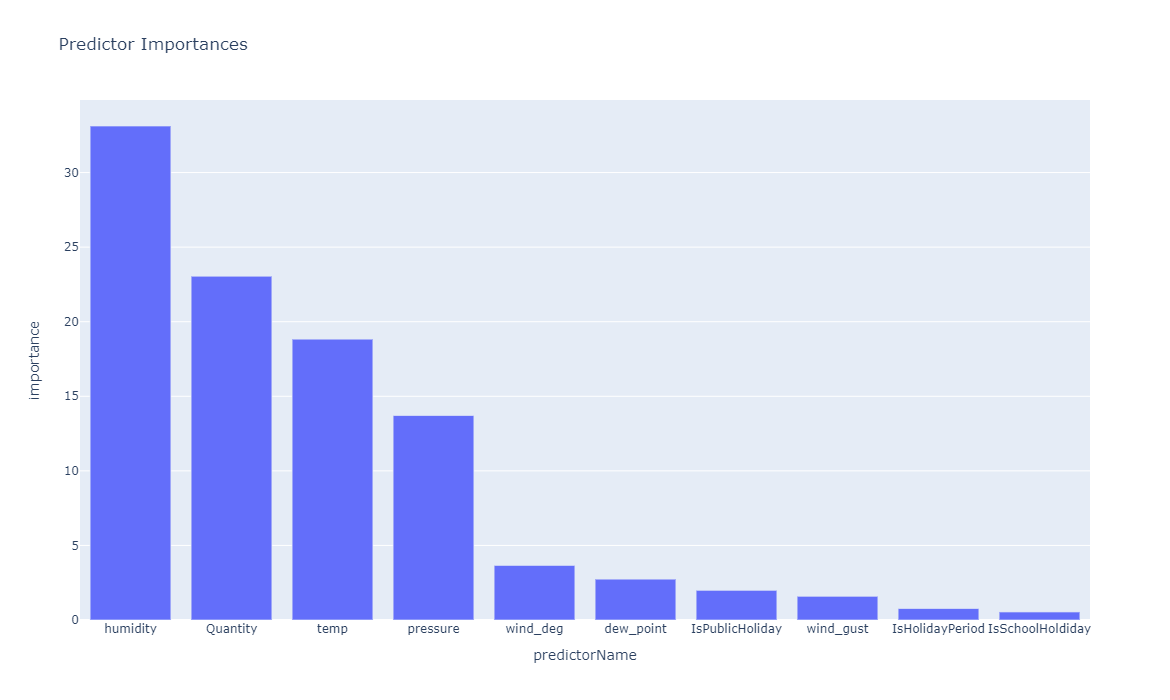

In [37]:
b_v_df = pi_df
x_axis = 'predictorName'
y_axis = 'importance'

fig1 = go.Figure(go.Bar(x=b_v_df[x_axis], y=b_v_df[y_axis]))
fig1.update_layout(height=700,width=1400,title_text='Predictor Importances',xaxis_title=x_axis,yaxis_title=y_axis)
print('Predictors not used:'+str(list(set(tim_input.columns[1:])-set(pi_df['predictorName']))))
fig1.show()

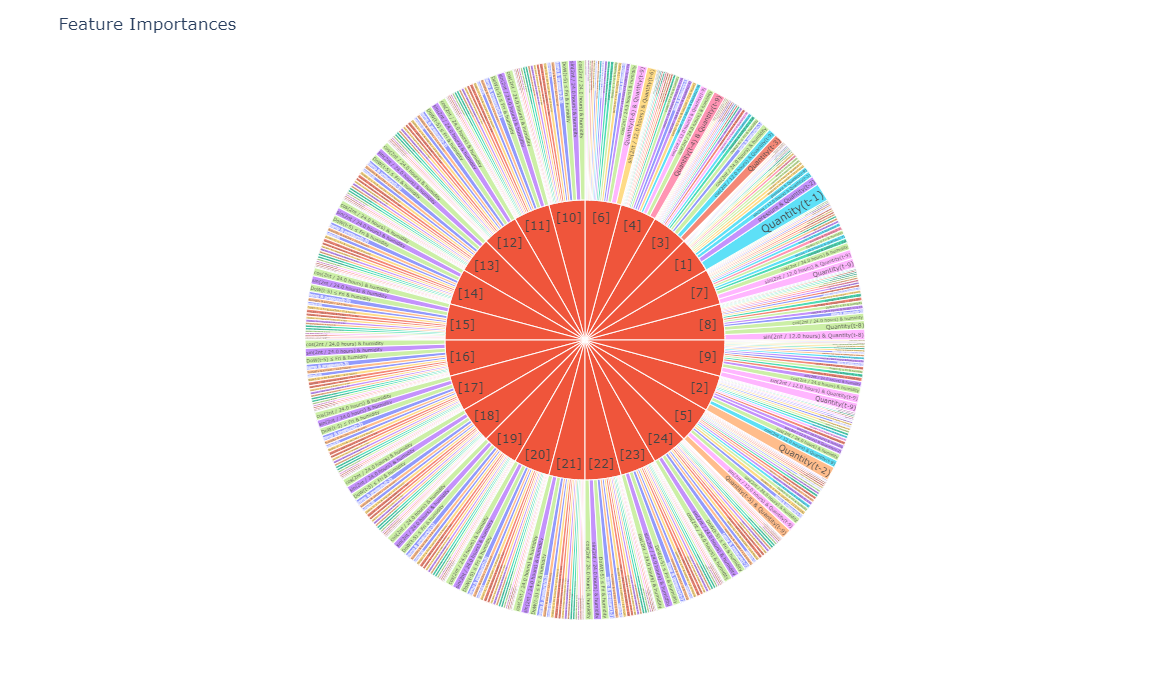

In [38]:
df = fi_df
fig = px.sunburst(df, path=['time','termName'], values='importance',color='termName')
fig.update_layout(height=700,width=700,title_text='Feature Importances')
fig.show()